# analysis question: what is the error mode of interleaved group?
### the goal of this notebook is to explore a few possible hypotheses (ken email 04/18/21) about how people in the interleaved group are failing
- the strategy corresponding to our "new adjusted rand" measure (always giving one response for cafe and the other response for brew house)
- responding correctly
- always choosing the same state; trackable by looking at the absolute value of .5 - (proportion of "5" responses)... this is maximal if the proportion of "5" responses is 1 or 0; OR, you could do adjusted rand vs. an "all zero" reference (you should make sure this is maximal for "100% fives" and "100% sixes")
- always pressing the same button; trackable in much the same way as always choosing the same state (except you look at the button and not the state)
- random responding (trackable using something like entropy -- this may end up being inversely proportional to, and thus redundant with, measures of "always choosing the same state")


- win-stay lose-shift
- simple greedy RL agent that tracks how often 5 and 6 responses have been rewarded and chooses the one that has been rewarded more

In [1]:
import os, re
import pandas as pd
import numpy as np
import json

from sklearn.metrics import adjusted_rand_score

from glob import glob as glob


from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('talk')
%matplotlib inline
plt.rcParams['font.size'] = 22

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from csw2022 import *

# load relevant dataframes
### need to pull out subjects response node to compare with schema

In [3]:
def load_df_with_state(condition,thresh=THRESHOLD):
  """ load dataframe and include information 
    about `tonode response` in dataframes 
  """
  ## load dataframe
  _df = load_final_df(condition,thresh)

  ## find right node and left node
  for i,d in _df.iterrows():
    # if true on right, right_node = true_tonode
    _df.loc[i,'right_state'] = node2stateD[
      [d.true_tonode,d.false_tonode][int(d.true_on_right)]
    ]
    _df.loc[i,'left_state'] = node2stateD[
      [d.true_tonode,d.false_tonode][np.abs(1-int(d.true_on_right))]
    ]
    # from_state and to_state
    _df.loc[i,'from_state'] = node2stateD[
      d.fromnode
    ]
    _df.loc[i,'to_state'] = node2stateD[
      d.true_tonode
    ]
    _df.loc[i,'to_state_false'] = node2stateD[
      d.false_tonode
    ]

  ## find response node
  for i,df_row in _df.iterrows():
    _df.loc[i,'response_state'] = [df_row.left_state,df_row.right_state][int(df_row.response_right)]
    _df.loc[i,'response_state_false'] = [df_row.right_state,df_row.left_state][int(df_row.response_right)]

  ## schema index
  _df.loc[:,'schema_idx'] = (_df.true_rfc.str.split('_').str[-1].str.split('-').str[1] == 'jungle').astype(int)

  return _df



In [4]:
condition = 'interleaved'
WINDOW = 20
TIMESTEP = 1


In [5]:
# load dataframe
fulldf = df = load_df_with_state(condition,thresh=THRESHOLD)

## subjects available after thresholding
df.index.get_level_values('subjnum').unique().values


-loading code version: RT01B1000cl
N = 55 subjects


array([ 1,  3,  5,  8,  9, 11, 12, 13, 16, 20, 21, 23, 24, 25, 27, 28, 29,
       30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48,
       49, 50, 51, 53, 54])

# TBD

In [6]:

def mov_avg(X,window=WINDOW):
  Y = -99*np.ones(len(X)-window)
  for ix in range(len(X)-window):
    Y[ix] = np.mean(X[ix:ix+window])
  return Y

def mov_avg_subdf(_sub_df):
  return mov_avg(_sub_df.correct_response.values)
  

def windowed_adjusted_rand(X,Y,window=WINDOW):
  assert len(X)==len(Y)
  AR = -99*np.ones(len(X)-window)
  for wi in range(len(X)-window):
    AR[wi] = adjusted_rand_score(
      X[wi:wi+window],
      Y[wi:wi+window]
    )
  return AR

def respond_same_node_adjrand_subdf(_sub_df,window=WINDOW):
  """ adjusted rand against constant sequence
  """
  ARmetric = windowed_adjusted_rand(
    X = _sub_df.response_state.values,
    Y = np.ones(len(_sub_df)),
    window=window
  )
  return ARmetric

def respond_same_node_counting_subdf(_sub_df,window=WINDOW):
  X = _sub_df.response_state.values
  R = -99*np.ones(len(X)-window)
  for ix in range(len(X)-window):
    R[ix] = np.sum(X[ix:ix+window]==5)/window
  return R

def windowed_entropy(X,window=WINDOW):
  binary_entropy_function = lambda p: -p*np.log2(p)-(1-p)*np.log2(1-p)
  R = -99*np.ones(len(X)-window)
  for ix in range(len(X)-window):
    p = np.mean(X[ix:ix+window]==X[0])
    R[ix] = binary_entropy_function(p)
  return R
    
def respond_randomly_subdf(_sub_df,window=WINDOW):
  R = windowed_entropy(
    _sub_df.response_state.values,
    window=window
  )
  return R

def respond_same_button_subdf(_sub_df,window=WINDOW):
  return np.abs(1-mov_avg(_sub_df.response_right.values,window=WINDOW))

In [7]:
def plt_sub_ax(sub_df,ax):
  E = respond_randomly_subdf(sub_df)
  S = respond_same_node_counting_subdf(sub_df)
  A = mov_avg_subdf(sub_df)

  ax.plot(A,c='g',label='correct')
  ax.plot(E,c='b',label='entropy')
  ax.plot(S,'purple',label='same')
  

In [8]:
get_fromstate_df = lambda df,state_ix: df[df.from_state == state_ix]
get_tstep_df = lambda df,tstep: df[df.index.get_level_values('depth') == tstep]
get_schema_df = lambda df,sch_ix: df[df.schema_idx == sch_ix]

<ipython-input-6-d8c56157a29c>:39: RuntimeWarning: divide by zero encountered in log2
  binary_entropy_function = lambda p: -p*np.log2(p)-(1-p)*np.log2(1-p)
<ipython-input-6-d8c56157a29c>:39: RuntimeWarning: invalid value encountered in double_scalars
  binary_entropy_function = lambda p: -p*np.log2(p)-(1-p)*np.log2(1-p)
<ipython-input-6-d8c56157a29c>:39: RuntimeWarning: divide by zero encountered in log2
  binary_entropy_function = lambda p: -p*np.log2(p)-(1-p)*np.log2(1-p)
<ipython-input-6-d8c56157a29c>:39: RuntimeWarning: invalid value encountered in double_scalars
  binary_entropy_function = lambda p: -p*np.log2(p)-(1-p)*np.log2(1-p)
<ipython-input-6-d8c56157a29c>:39: RuntimeWarning: divide by zero encountered in log2
  binary_entropy_function = lambda p: -p*np.log2(p)-(1-p)*np.log2(1-p)
<ipython-input-6-d8c56157a29c>:39: RuntimeWarning: invalid value encountered in double_scalars
  binary_entropy_function = lambda p: -p*np.log2(p)-(1-p)*np.log2(1-p)
<ipython-input-6-d8c56157a29c>:

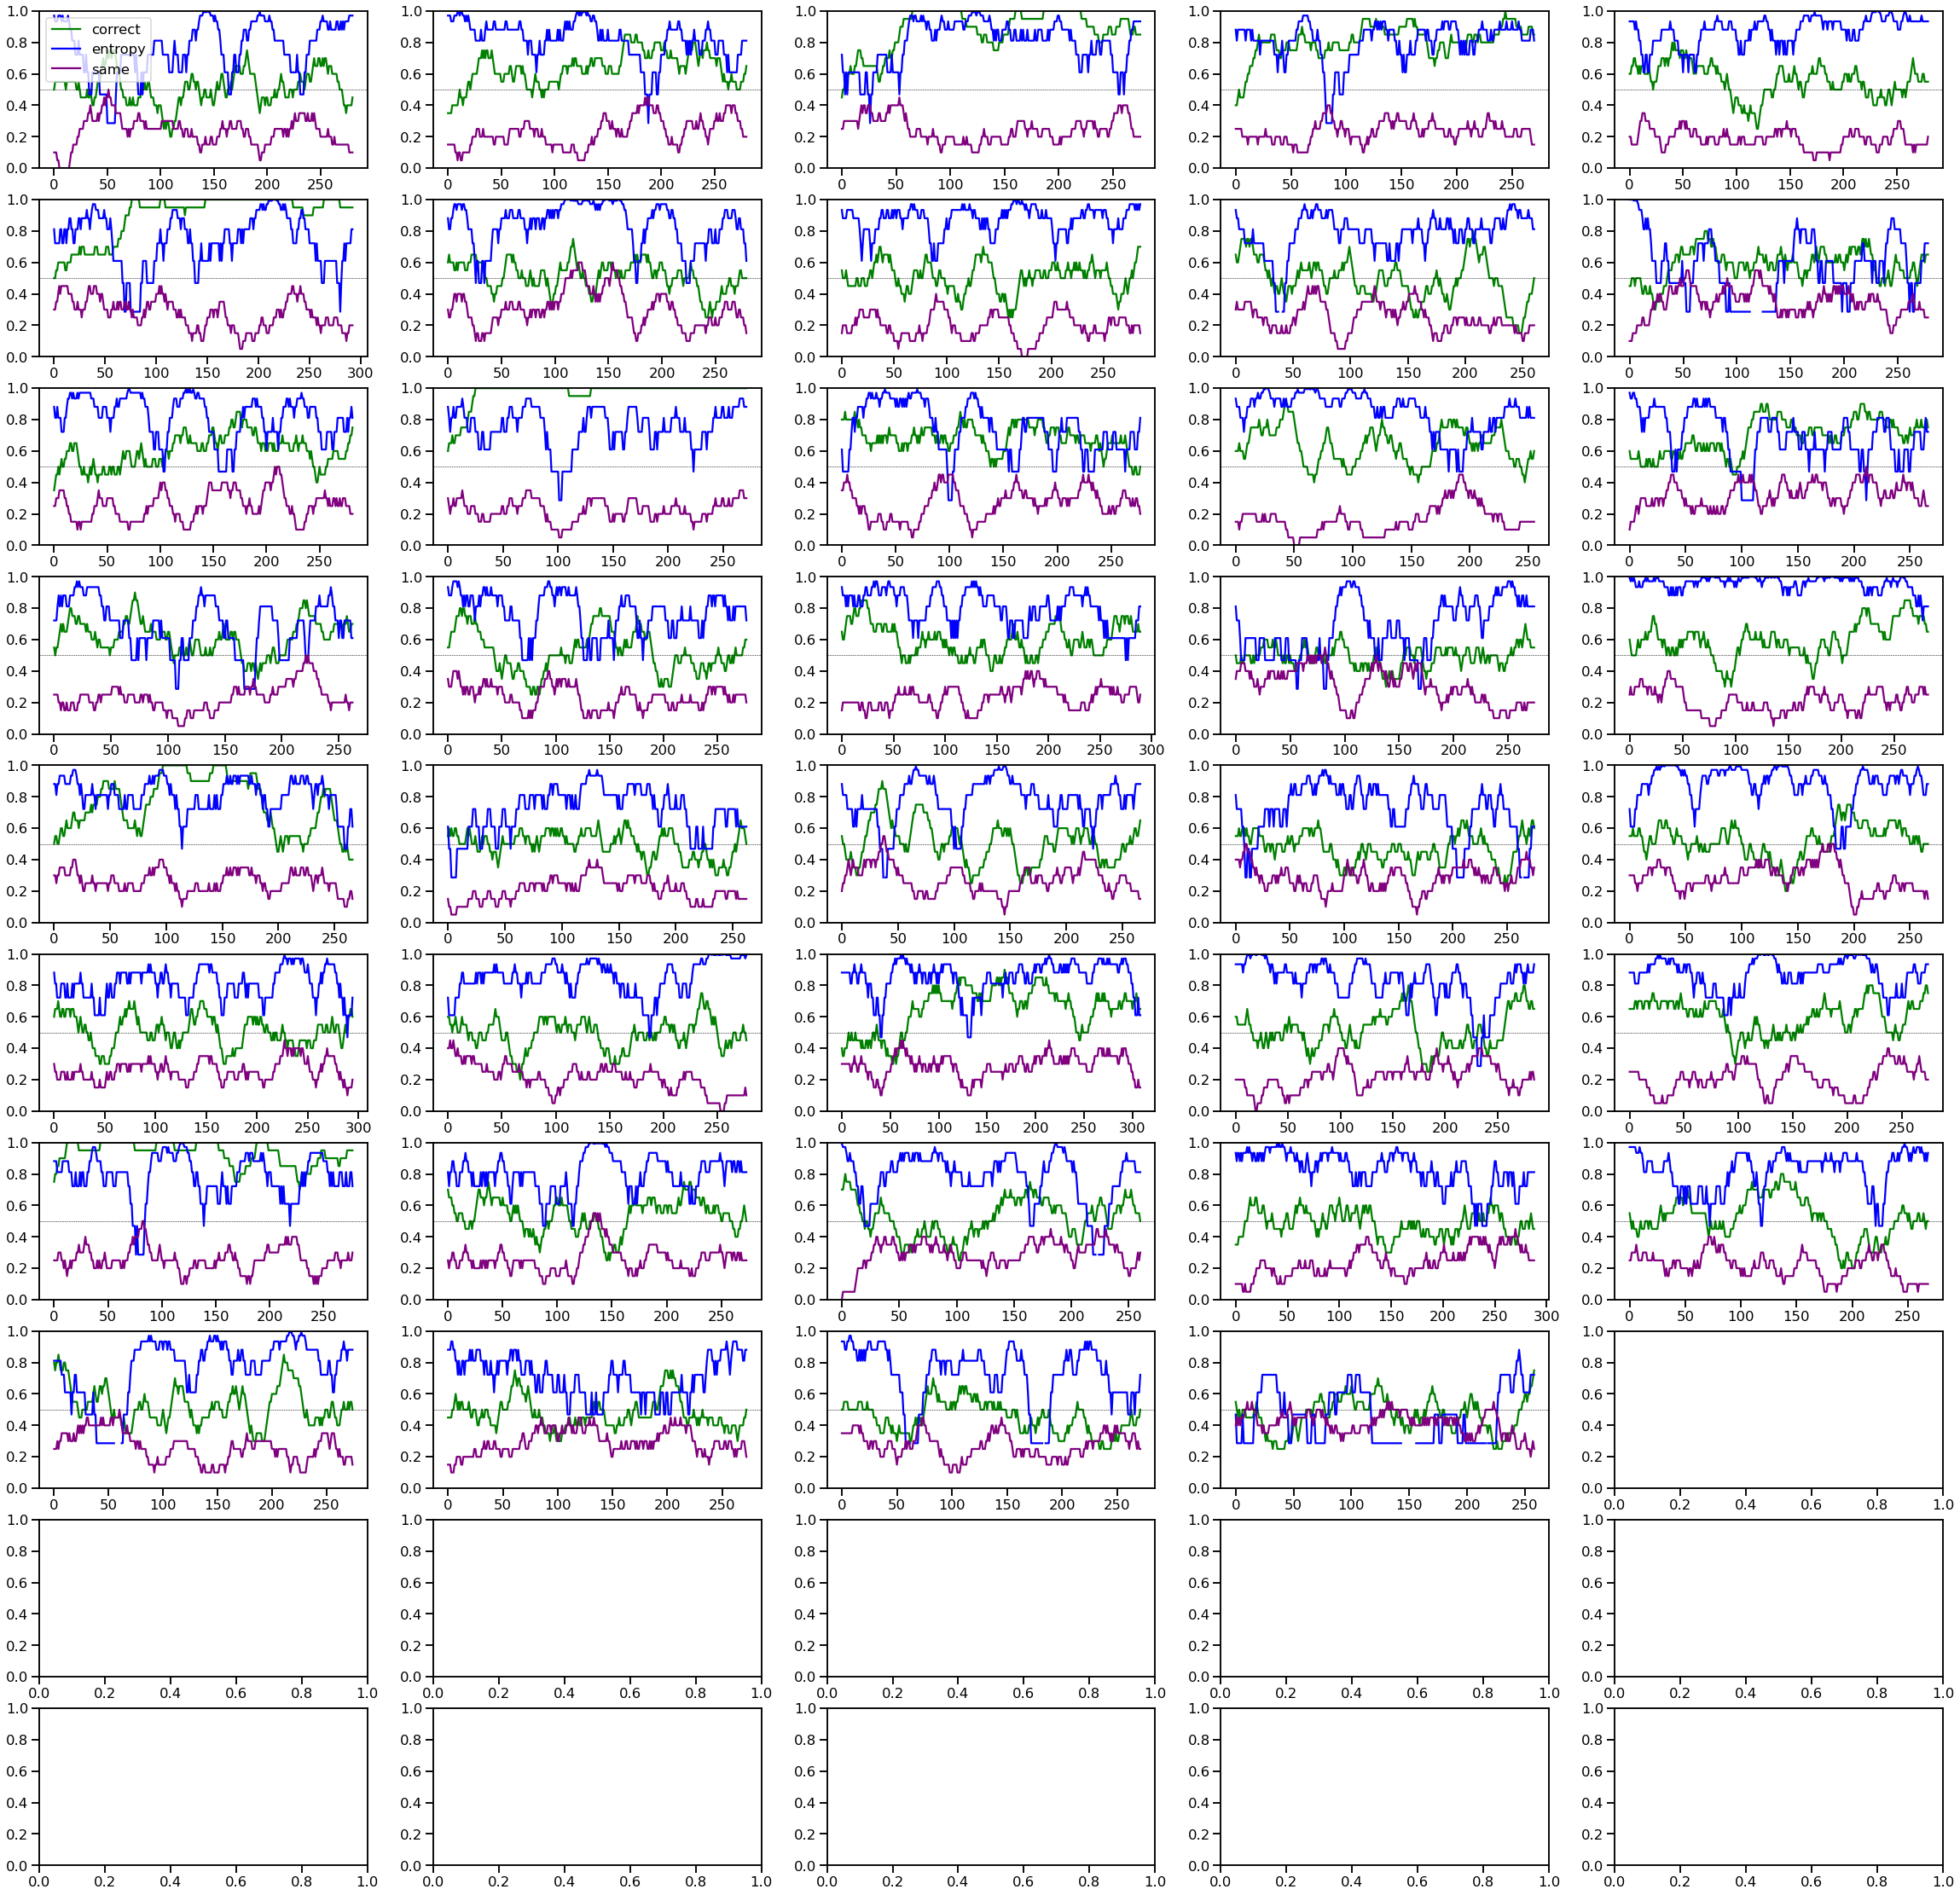

In [12]:
fg,axar = plt.subplots(10,5,figsize=(40,40));axar=axar.reshape(-1)
for ix,(sidx,sub_df) in enumerate(df.groupby('subjnum')):
  ## manipulate subdf
#   sub_df = get_tstep_df(sub_df,TIMESTEP)
#   sub_df = get_fromstate_df(sub_df,4)
#   sub_df = get_schema_df(sub_df,1)
  ##
  
  ax=axar[ix]
  plt_sub_ax(sub_df,ax)
  ax.set_ylim(0,1)
  ax.axhline(0.5,c='k',ls='--',lw=0.5)
axar[0].legend()

In [70]:
def winstay_looseshift_responses(sub_df):
  """ 
  if correct, choose same to_state next time from_state is observed
  """
  strat_response = -np.ones(len(sub_df))
#   print(strat_response)
  # relevant to_states are 5,6,7,8
  strat_response_map = np.concatenate([
    np.random.choice([5,6],2),
    np.random.choice([7,8],2)
  ])
  for ix,(_,row) in enumerate(sub_df.iterrows()):
    strat_response[ix] = strat_response_map[int(row.from_state)-3]
    # relevant from_states are 3,4,5,6 
    strat_response_map[int(row.from_state)-3] = [
      row.response_state_false,row.response_state
    ][row.correct_response]

  return strat_response

strat_resp = winstay_looseshift_responses(sub_df)


In [73]:
windowed_adjusted_rand(sub_df.response_state.values,strat_resp)

array([0.43494424, 0.44946996, 0.41068659, 0.44946996, 0.39638989,
       0.40944882, 0.35711265, 0.39575972, 0.37164117, 0.35153584,
       0.37314012, 0.34545956, 0.33926833, 0.33926833, 0.35751227,
       0.36569759, 0.37121532, 0.33454749, 0.3612045 , 0.30157758,
       0.35977945, 0.35977945, 0.32152953, 0.30157758, 0.29325993,
       0.28301887, 0.31169811, 0.33067851, 0.38888038, 0.34997816,
       0.31338537, 0.31338537, 0.31338537, 0.35856917, 0.35856917,
       0.35856917, 0.38877481, 0.43275885, 0.39361702, 0.3791695 ,
       0.37118754, 0.36776254, 0.36459016, 0.38119148, 0.38119148,
       0.4063273 , 0.44774739, 0.43113772, 0.46721859, 0.41168191,
       0.35066865, 0.3494079 , 0.35018587, 0.34151625, 0.34151625,
       0.36534447, 0.36534447, 0.35540779, 0.35540779, 0.40353172,
       0.40353172, 0.47834769, 0.50125283, 0.50125283, 0.50125283,
       0.54960294, 0.48401432, 0.48850952, 0.45323741, 0.45714286,
       0.47255521, 0.46961046, 0.39754261, 0.39754261, 0.42961